In [1]:
!pip install pyfolio-reloaded
!pip install backtrader
!pip install yfinance

In [5]:
# import yfinance as yf
# # В этот раз загрузим данные для Nasdaq-100 за последние 25 лет
# data = yf.download('NQ=F', start='2001-01-01', end='2025-01-01')
# data.to_csv('NQ_Futures.csv')
# print(data.head())

[*********************100%***********************]  1 of 1 completed

Price        Close    High          Low         Open  Volume
Ticker        NQ=F    NQ=F         NQ=F         NQ=F    NQ=F
Date                                                        
2001-01-02  2167.5  2414.0  2130.500000  2375.000000   87316
2001-01-03  2529.5  2590.0  2201.840088  2201.840088  115138
2001-01-04  2486.0  2577.0  2464.500000  2532.000000   94119
2001-01-05  2293.5  2551.0  2273.500000  2485.000000   94688
2001-01-08  2325.0  2328.0  2171.000000  2290.000000   92841


In [704]:
import backtrader as bt
import datetime
import matplotlib.pyplot as plt

class ROCMomentumStrategy(bt.Strategy):
    params = (
        ('roc_period', 20),
        ('risk_percent', 0.12),
    )

    #Новая упрощённая формула расчёта количетсва покупаемых лотов
    def getsizing(self, cash, close):
        risk_amount = cash * 0.2
        size = int(risk_amount / close)
        return size
    
    def log(self, txt, dt=None):
        dt = dt or self.datas[0].datetime.date(0)
        print('%s, %s' % (dt.isoformat(), txt))

    def __init__(self):
        self.roc = bt.indicators.RateOfChange100(self.data.close, period=self.params.roc_period)

    def next(self):
        cash = self.broker.get_cash()
        size = self.getsizing(cash, self.data.close[0])

        if not self.position:
            if self.roc[0] > :
                # self.log(f'BUY CREATE, {self.data.close[0]:.2f}')
                self.buy(size=size)
        else:
            if self.roc[0] < -5:
                # self.log(f'SELL CREATE, {self.data.close[0]:.2f}')
                self.sell(size=self.position.size)

In [630]:
def test_strategy(data, periods):
    results = []

    for period in periods:
        cerebro = bt.Cerebro()
        cerebro.addstrategy(ROCMomentumStrategy, roc_period=period)
        cerebro.adddata(data)
        cerebro.broker.setcash(100000)
        cerebro.broker.setcommission(commission=0.001)

        cerebro.addanalyzer(bt.analyzers.Returns, _name='returns')
        cerebro.addanalyzer(bt.analyzers.DrawDown, _name='drawdown')

        result = cerebro.run()[0]

        cumulative_return = result.analyzers.returns.get_analysis().get('rtot', 0)
        max_drawdown = result.analyzers.drawdown.get_analysis().get('max', 0)

        results.append((period, cumulative_return, max_drawdown))

    return pd.DataFrame(results, columns=['ROC Period', 'Cumulative Return', 'Max Drawdown'])

data = bt.feeds.GenericCSVData(
    dataname=os.path.join(cur_dir, 'NQ_Futures.csv'),
    dtformat='%Y-%m-%d',
    timeframe=bt.TimeFrame.Days,
    fromdate=datetime.datetime(2001, 1, 1),
    todate=datetime.datetime(2018, 1, 1),
    # Указываем индексы столбцов
    close=1,
    high=2,
    low=3,
    open=4,
    volume=5,
    openinterest=-1
)

roc_periods = range(5, 70, 2)

stats = test_strategy(data, roc_periods)
stats['Max Drawdown'] = stats['Max Drawdown'].apply(lambda x: x['drawdown'] if isinstance(x, dict) else None)

In [634]:
print(stats)

    ROC Period  Cumulative Return  Max Drawdown
0            5          -0.106156     20.190895
1            7          -0.153180     22.544276
2            9          -0.101216     15.346571
3           11          -0.066826     16.359454
4           13           0.012089      7.766731
5           15           0.057660      7.423113
6           17           0.127465      6.352251
7           19           0.083966      8.637008
8           21           0.082764     11.565717
9           23           0.150690      6.164605
10          25           0.076855      8.913685
11          27           0.174200      6.242113
12          29           0.209393      8.426466
13          31           0.074862      8.648724
14          33           0.074172      8.471966
15          35           0.198677      5.521202
16          37           0.160604      6.398312
17          39           0.216185      6.643751
18          41           0.181799      6.553127
19          43           0.219741      5

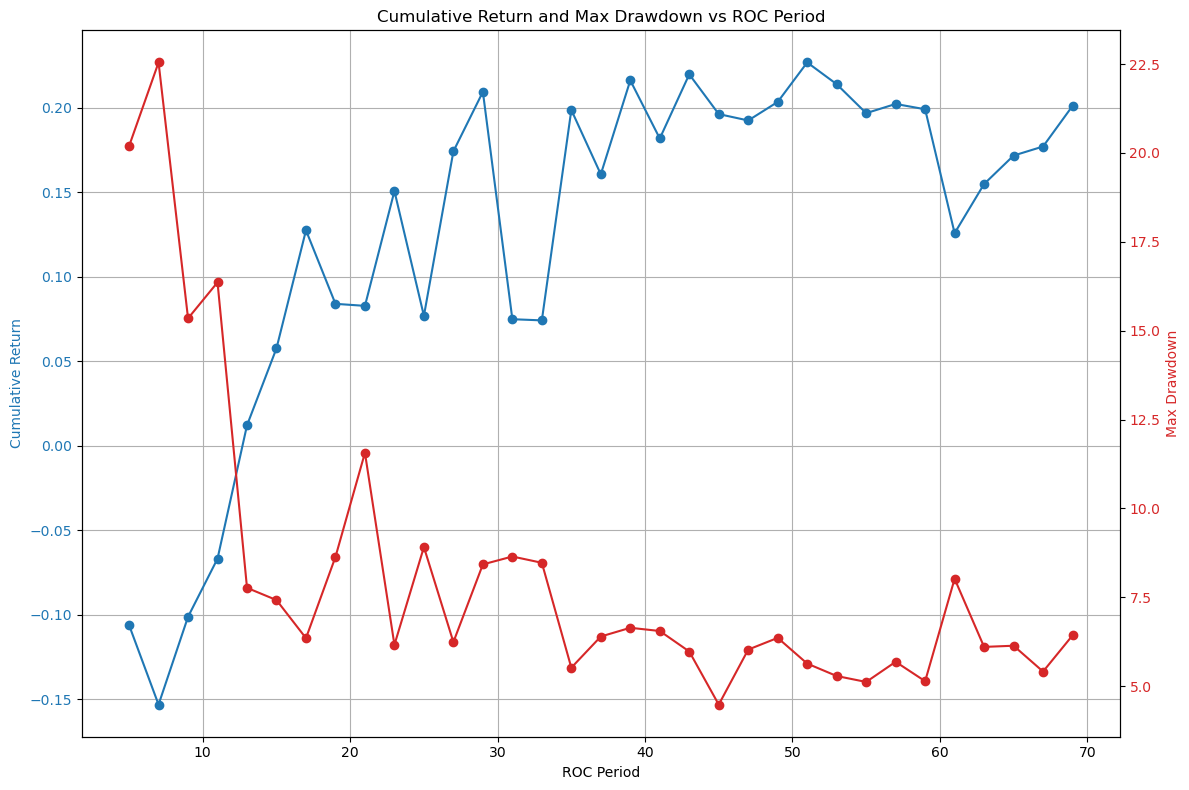

In [636]:
# import matplotlib.pyplot as plt
# stats_pivot = stats.pivot(index = 'ROC Period', columns = 'Max Drawdown', values = 'Cumulative Return')

# plt.imshow(stats_pivot, aspect = 'auto', interpolation = 'none')
# # plt.xticks(np.arange(len(stats['Max Drawdown'])), stats['Max Drawdown'], rotation = 90)
# # plt.yticks(np.arange(len(stats['ROC Period'])), stats['ROC Period'])
# plt.title('Cumulative Return')
# plt.xlabel('Max Drawdown')
# plt.ylabel('ROC Period')
# plt.savefig('heatmap_cumulative_return.png', dpi=300, bbox_inches='tight')
# %matplotlib inline

# plt.colorbar()

fig, ax1 = plt.subplots(figsize=(12, 8))

color = 'tab:blue'
ax1.set_xlabel('ROC Period')
ax1.set_ylabel('Cumulative Return', color=color)
ax1.plot(stats['ROC Period'], stats['Cumulative Return'], marker='o', color=color, label='Cumulative Return')
ax1.tick_params(axis='y', labelcolor=color)
ax1.grid()

ax2 = ax1.twinx()
color = 'tab:red'
ax2.set_ylabel('Max Drawdown', color=color)
ax2.plot(stats['ROC Period'], stats['Max Drawdown'], marker='o', color=color, label='Max Drawdown')
ax2.tick_params(axis='y', labelcolor=color)

plt.title('Cumulative Return and Max Drawdown vs ROC Period')

plt.tight_layout()
plt.show()

In [638]:
data = bt.feeds.GenericCSVData(
    dataname=os.path.join(cur_dir, 'NQ_Futures.csv'),
    dtformat='%Y-%m-%d',      # Формат даты
    timeframe=bt.TimeFrame.Days,  # Таймфрейм данных (дневной)
    fromdate=datetime.datetime(2018, 1, 1),
    # Указываем индексы столбцов
    close=1,
    high=2,
    low=3,
    open=4,
    volume=5,
    openinterest=-1
)

roc_periods = range(5, 70, 2)

stats = test_strategy(data, roc_periods)
stats['Max Drawdown'] = stats['Max Drawdown'].apply(lambda x: x['drawdown'] if isinstance(x, dict) else None)

print(stats)

    ROC Period  Cumulative Return  Max Drawdown
0            5           0.035715      4.583155
1            7           0.096527      4.256693
2            9           0.140693      4.203765
3           11           0.119145      3.146817
4           13           0.096434      3.647486
5           15           0.082853      3.955520
6           17           0.090083      5.385506
7           19           0.100149      3.929148
8           21           0.088209      6.242071
9           23           0.080415      5.244341
10          25           0.086603      4.920674
11          27           0.090579      4.487505
12          29           0.099326      6.142535
13          31           0.057073      6.809219
14          33           0.061495      7.958084
15          35           0.066412      5.623799
16          37           0.064762      5.512353
17          39           0.104382      3.654750
18          41           0.087410      4.085762
19          43           0.094608      4

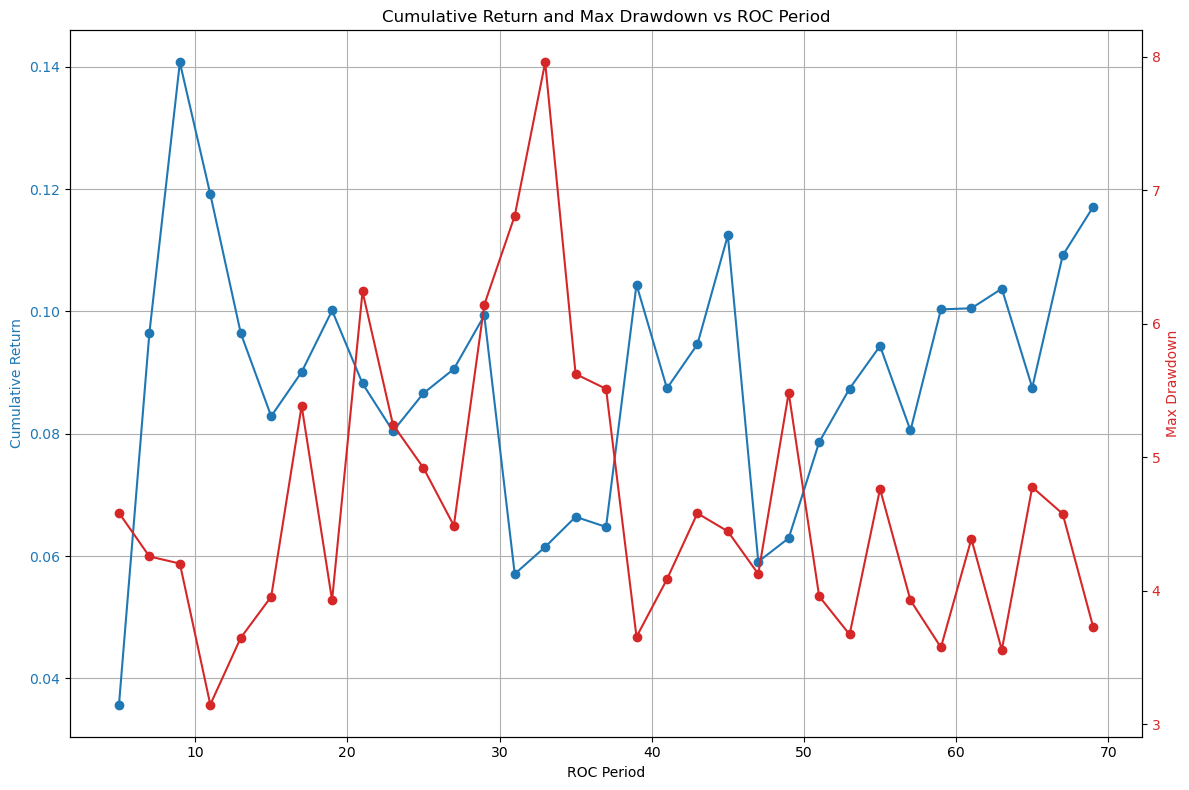

In [644]:
fig, ax1 = plt.subplots(figsize=(12, 8))

color = 'tab:blue'
ax1.set_xlabel('ROC Period')
ax1.set_ylabel('Cumulative Return', color=color)
ax1.plot(stats['ROC Period'], stats['Cumulative Return'], marker='o', color=color, label='Cumulative Return')
ax1.tick_params(axis='y', labelcolor=color)
ax1.grid()

ax2 = ax1.twinx()
color = 'tab:red'
ax2.set_ylabel('Max Drawdown', color=color)
ax2.plot(stats['ROC Period'], stats['Max Drawdown'], marker='o', color=color, label='Max Drawdown')
ax2.tick_params(axis='y', labelcolor=color)

plt.title('Cumulative Return and Max Drawdown vs ROC Period')

plt.tight_layout()
plt.show()

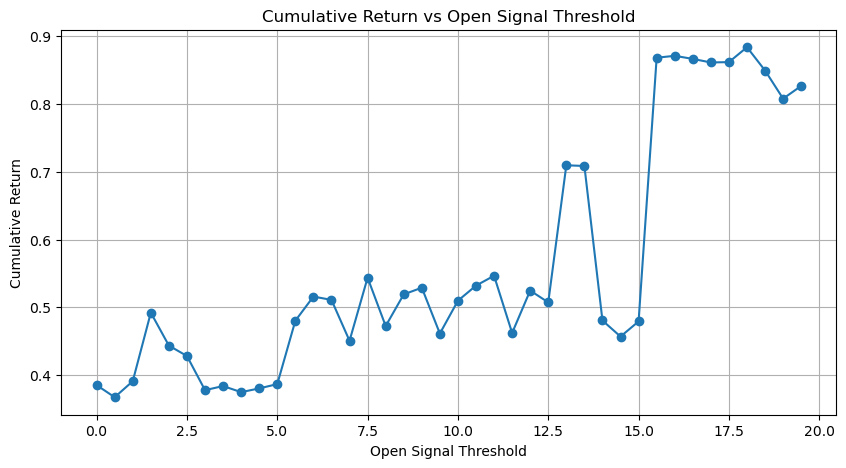

In [779]:
class ROCMomentumStrategy(bt.Strategy):
    params = (("open_signal", 10),
                "close_signal, 10)

    def getsizing(self, cash, close):
        risk_amount = cash * 0.2
        size = int(risk_amount / close)
        return size
    
    def log(self, txt, dt=None):
        dt = dt or self.datas[0].datetime.date(0)
        # print(f"{dt.isoformat()}, {txt}")

    def __init__(self):
        self.roc = bt.indicators.RateOfChange100(self.data.close, period=)

    def next(self):
        cash = self.broker.get_cash()
        size = self.getsizing(cash, self.data.close[0])

        if not self.position:
            if self.roc[0] > self.params.open_signal:
                self.log(f"BUY CREATE, {self.data.close[0]:.2f}")
                self.buy(size=size)
        else:
            if self.roc[0] < -self.params.close_signal:
                self.log(f"SELL CREATE, {self.data.close[0]:.2f}")
                self.sell(size=self.position.size)

open_signal_values = np.arange(0, 20, 0.5)  # Тестируем от 5 до 45 с шагом 5
close_signal_values = np.arange(0, 20, 0.5)
cumulative_returns = []

data = bt.feeds.GenericCSVData(
    dataname=os.path.join(cur_dir, 'NQ_Futures.csv'),
    dtformat='%Y-%m-%d',
    timeframe=bt.TimeFrame.Days,
    fromdate=datetime.datetime(2004, 1, 1),
    tomdate=datetime.datetime(2008, 1, 1),
    close=1,
    high=2,
    low=3,
    open=4,
    volume=5,
    openinterest=-1
)

for open_signal in open_signal_values:
    for close_signal in close_signal_values:
        open_signal_values = np.arange(0, 20, 0.5)
        cerebro = bt.Cerebro()
        cerebro.addstrategy(ROCMomentumStrategy, open_signal=open_signal)
        cerebro.adddata(data)
        cerebro.broker.set_cash(100000)
        cerebro.run()
        portfolio_value = cerebro.broker.get_value()
        cumulative_returns.append((portfolio_value - 100000) / 100000)

stats_pivot = stats.pivot(index = 'period', columns = 'scale', values = 'Sharpe ratio')

plt.imshow(stats_pivot, aspect = 'auto', interpolation = 'none')
plt.xticks(np.arange(len(scales)), scales, rotation = 90)
plt.yticks(np.arange(len(periods)), periods)
plt.title('Sharpe coef')
plt.xlabel('Scale')
plt.ylabel('Period')

plt.figure(figsize=(10, 5))
plt.plot(open_signal_values, cumulative_returns, marker="o", linestyle="-")
plt.xlabel("Open Signal Threshold")
plt.ylabel("Cumulative Return")
plt.title("Cumulative Return vs Open Signal Threshold")
plt.grid(True)
plt.show()

Сделаем финальное и наверное самое интересное исследование зависимости шарпа от параметров открытия и закрыия позиции (многомерный анализ), сначала просто проведём исследование на тренировочной выборке.
```[python]
if not self.position:
    if self.roc[0] > self.params.open_signal:
        self.buy(size=size)
else:
    if self.roc[0] < -self.params.close_signal:
        self.sell(size=self.position.size)```

In [123]:
import numpy as np
import backtrader as bt
import os
import datetime
import matplotlib.pyplot as plt
import pandas as pd
import pyfolio as pf
import warnings
warnings.filterwarnings('ignore')
import pyfolio as pf


open_signal_values = np.arange(1, 10, 0.5)
close_signal_values = np.arange(1, 10, 0.5)

def load_data(start_year, end_year):
    cur_dir = os.getcwd()  
    data = bt.feeds.GenericCSVData(
        dataname=os.path.join(cur_dir, 'NQ_Futures.csv'),
        dtformat='%Y-%m-%d',
        timeframe=bt.TimeFrame.Days,
        fromdate=datetime.datetime(start_year, 1, 1),
        todate=datetime.datetime(end_year, 1, 1),
        open=4,
        high=2,
        low=3,
        close=1,
        volume=5,
        openinterest=-1
    )
    return data

class ROCMomentumStrategy(bt.Strategy):
    params = (("open_signal", 10),
              ("close_signal", 10))

    def __init__(self):
        self.roc = bt.indicators.RateOfChange100(self.data.close, period=10)
        self.portfolio_values = []  # Храним значения портфеля
        
    def next(self):
        cash = self.broker.get_cash()
        size = int((cash * 0.2) / self.data.close[0])

        self.portfolio_values.append(self.broker.get_value())

        if not self.position:
            if self.roc[0] > self.params.open_signal:
                self.buy(size=size)
        else:
            if self.roc[0] < -self.params.close_signal:
                self.sell(size=self.position.size)
                
def test_strategy(start_year, end_year):
    results = []

    for open_signal in open_signal_values:
        for close_signal in close_signal_values:
            cerebro = bt.Cerebro()
            strategy = ROCMomentumStrategy

            cerebro.addstrategy(strategy, open_signal=open_signal, close_signal=close_signal)
            cerebro.adddata(load_data(start_year, end_year))
            cerebro.broker.set_cash(1000000)
            cerebro.run()
            
            portfolio_values = cerebro.runstrats[0][0].portfolio_values  
            returns = pd.Series(np.diff(portfolio_values) / portfolio_values[:-1])
            
            sharpe_ratio = pf.timeseries.sharpe_ratio(returns)
            
            results.append([open_signal, close_signal, sharpe_ratio])

    stats = pd.DataFrame(results, columns=['open_signal', 'close_signal', 'sharpe_ratio'])
    
    stats_pivot = stats.pivot(index='open_signal', columns='close_signal', values='sharpe_ratio')

    # Plot heatmap
    plt.figure(figsize=(10, 8))
    plt.imshow(stats_pivot, aspect='auto', interpolation='none', cmap='coolwarm')

    # Set ticks and labels
    plt.xticks(ticks=np.arange(len(close_signal_values)), labels=close_signal_values, rotation=90)
    plt.yticks(ticks=np.arange(len(open_signal_values)), labels=open_signal_values)
    plt.title('Sharpe Ratio Heatmap')
    plt.xlabel('Close Signal')
    plt.ylabel('Open Signal')
    plt.colorbar(label='Sharpe Ratio')

    # Show plot
    plt.show()


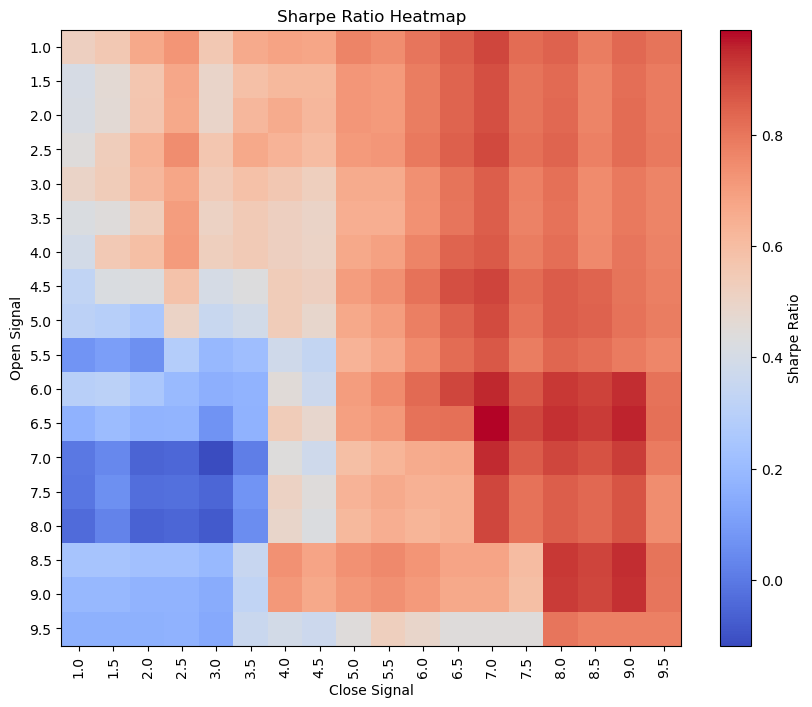

In [129]:
test_strategy(2009, 2019)

In [ ]:
Как мы видим максимальное значение шарпа наблюдается в нижнем правом углу хитмапы в окрестности (7.0, 7.0), проверим на тестовой выборке.

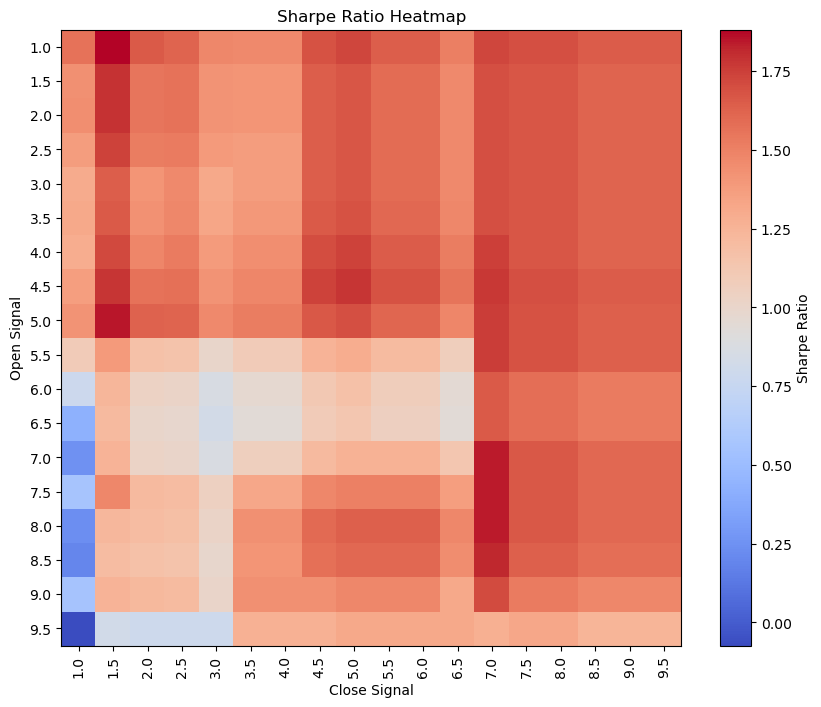

In [131]:
test_strategy(2019, 2021)

In [ ]:
Видно, что в окрестности (7, 7) сохраняестя тенденция повышенного шарпа. Протестируем на волк-форфард алгоритме

In [125]:
def walk_forward_test(start_year, end_year, train_years=4, test_years=2):
    results = []
    
    current_start = start_year
    print('test_start', 'test_end', 'open_signal', 'close_signal', 'best_sharpe', 'sharpe_ratio')
    while current_start + train_years + test_years <= end_year:
        train_start = current_start
        train_end = train_start + train_years
        test_start = train_end
        test_end = test_start + test_years
        
        print(f"Тренировочный период: {train_start}-{train_end}, Тестовый период: {test_start}-{test_end}")
        
        best_params = None
        best_sharpe = -np.inf
        
        # Оптимизация на обучающем периоде
        for open_signal in open_signal_values:
            for close_signal in close_signal_values:
                cerebro = bt.Cerebro()
                cerebro.addstrategy(ROCMomentumStrategy, open_signal=open_signal, close_signal=close_signal)
                cerebro.adddata(load_data(train_start, train_end))
                cerebro.broker.set_cash(1000000)
                cerebro.run()
                
                portfolio_values = cerebro.runstrats[0][0].portfolio_values  
                returns = pd.Series(np.diff(portfolio_values) / portfolio_values[:-1])
                sharpe_ratio = pf.timeseries.sharpe_ratio(returns)
                
                if sharpe_ratio > best_sharpe:
                    best_sharpe = sharpe_ratio
                    best_params = (open_signal, close_signal)
        
        # Тестирование на тестовом периоде
        cerebro = bt.Cerebro()
        cerebro.addstrategy(ROCMomentumStrategy, open_signal=best_params[0], close_signal=best_params[1])
        cerebro.adddata(load_data(test_start, test_end))
        cerebro.broker.set_cash(1000000)
        cerebro.run()
        
        portfolio_values = cerebro.runstrats[0][0].portfolio_values  
        returns = pd.Series(np.diff(portfolio_values) / portfolio_values[:-1])
        sharpe_ratio = pf.timeseries.sharpe_ratio(returns)

        print(test_start, test_end, best_params[0], best_params[1], best_sharpe, sharpe_ratio)
        # results.append([test_start, test_end, best_params[0], best_params[1], best_sharpe, sharpe_ratio])
        
        current_start += test_years    



In [127]:
walk_forward_test(2000, 2025)

test_start test_end open_signal close_signal best_sharpe sharpe_ratio
Training period: 2000-2004, Testing period: 2004-2006
2004 2006 7.5 6.5 0.5139524485760443 -0.4591302933199376
Training period: 2002-2006, Testing period: 2006-2008
2006 2008 5.5 7.5 0.5313878260940527 0.6586577772301938
Training period: 2004-2008, Testing period: 2008-2010
2008 2010 3.5 3.5 0.9451738715447412 0.7887776558920434
Training period: 2006-2010, Testing period: 2010-2012
2010 2012 3.5 4.0 0.8637600527592894 0.055962255455138624
Training period: 2008-2012, Testing period: 2012-2014
2012 2014 8.5 8.0 0.7166674595803952 nan
Training period: 2010-2014, Testing period: 2014-2016
2014 2016 2.5 2.5 1.3222364696693483 -0.2822501972176717
Training period: 2012-2016, Testing period: 2016-2018
2016 2018 3.0 1.0 1.0794180596836314 0.15341984473861575
Training period: 2014-2018, Testing period: 2018-2020
2018 2020 8.5 4.0 1.3010709638341793 0.5074858804246942
Training period: 2016-2020, Testing period: 2020-2022
2020 2

ValueError: 5 columns passed, passed data had 6 columns

Сделаем качественный анализ полученных результатов работы walk-farward алгоритма: 
```
test_start test_end open_signal close_signal best_sharpe sharpe_ratio
Training period: 2000-2004, Testing period: 2004-2006
2004 2006 7.5 6.5 0.5139524485760443 -0.4591302933199376 - мимо
Training period: 2002-2006, Testing period: 2006-2008
2006 2008 5.5 7.5 0.5313878260940527 0.6586577772301938 - значение отличаются не сильно
Training period: 2004-2008, Testing period: 2008-2010
2008 2010 3.5 3.5 0.9451738715447412 0.7887776558920434 - значения отличаются тоже несильно
Training period: 2006-2010, Testing period: 2010-2012
2010 2012 3.5 4.0 0.8637600527592894 0.055962255455138624 - мимо (((
Training period: 2008-2012, Testing period: 2012-2014
2012 2014 8.5 8.0 0.7166674595803952 nan - мимо
Training period: 2010-2014, Testing period: 2014-2016
2014 2016 2.5 2.5 1.3222364696693483 -0.2822501972176717 - мимо
Training period: 2012-2016, Testing period: 2016-2018
2016 2018 3.0 1.0 1.0794180596836314 0.15341984473861575 - мимо
Training period: 2014-2018, Testing period: 2018-2020
2018 2020 8.5 4.0 1.3010709638341793 0.5074858804246942 - 
Training period: 2016-2020, Testing period: 2020-2022
2020 2022 6.0 7.0 1.4241427046581703 1.321934712294271 - оптимизация хорошо предсказала и при этом Шарп >1 !!!
Training period: 2018-2022, Testing period: 2022-2024
2022 2024 7.0 7.0 1.287261687909955 0.35623611447738207
```

Сделаем ещё некоторое интересное наблюдение о том что, при оптимизации стратегии сигналы открытия и закрытия почти всегда совпадаают с точностью до +-1, и это может нас наталкивать на новые гипотезы о том что возможно стоит попробовать поиследовать зависимости шарпа от пары (сигнал открытия == сигналу заакрытия, период roc)

По мнению автора, какой-то зависимости шарпа от двух параметров нет, да и самого его значение в окрестности 1 мы получили только несколько раз, но само её исследование демонстрирует понимание автором стратегий простейшей оптимищации (очевидный перебор) и понимание работы walk-farward алгоритма